In [1]:
import hashlib
import logging
import os
import pickle
from threading import Thread
from time import time

import networkx as nx
import numpy as np
from krakow import krakow
from krakow.utils import create_dendrogram, split_into_n_children
from scipy.cluster.hierarchy import to_tree

from yourtube.file_operations import clustering_cache_template
from yourtube.filtering_functions import *
from yourtube.scraping import Scraper
from yourtube.recommendation import cluster_subgraph


In [2]:

with open("../tests/nodes_to_cluster_example.pickle", "rb") as handle:
    nodes_to_cluster = pickle.load(handle)
with open("../tests/G_example.pickle", "rb") as handle:
    G = pickle.load(handle)



In [3]:
# G.nodes.get("rrmy9Of6bo")

In [4]:
def balance_on_single_node(node):
    """
    ideal balance (0.5, 0.5) gives a score 0
    any inbalance returns negative score
    """
    if node.is_leaf() or node.left.is_leaf() or node.right.is_leaf():
        # TODO is this robust? maybe give some penalty instead
        # this will never be a problem if we stay near the top layers
        return 0
    left_ratio = node.left.count / node.count
    right_ratio = node.right.count / node.count
    return 2 + np.log2(left_ratio) + np.log2(right_ratio)


def get_top_levels_balance_log(tree, levels=5):
    """
    how disbalanced are top levels of the tree
    any inbalance returns negative score, 0 is perfect
    """
    balance_on_levels = []

    nodes = [tree]
    for _ in range(levels):
        balances_on_one_level = [balance_on_single_node(node) for node in nodes]
        balance_on_levels.append(np.average(balances_on_one_level))

        new_nodes = []
        for node in nodes:
            if node.is_leaf():
                continue
            if node.left is not None:
                new_nodes.append(node.left)
            if node.right is not None:
                new_nodes.append(node.right)
        nodes = new_nodes

    return np.average(balance_on_levels)

In [5]:
def depth_of_leaves(tree):
    if tree.is_leaf():
        return [0]
    
    left = depth_of_leaves(tree.left)
    right = depth_of_leaves(tree.right)

    return [depth + 1 for depth in left + right]

def get_disbalance(tree):
    """
    how much higher is the average leaf depth, than in an ideally balanced tree
    """
    depths = depth_of_leaves(tree)
    return np.average(depths) - np.log2(tree.count)

In [6]:
resolution = 61
alphas = np.linspace(1, 1.6, resolution)
betas = np.linspace(1, 1.6, resolution)
alphas


array([1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 ])

In [6]:
# perform a grid search over all many possible alphas and betas
clustering_qualities = [[None for _ in range(resolution)] for _ in range(resolution)]
disbalances = [[None for _ in range(resolution)] for _ in range(resolution)]
top_balances = [[None for _ in range(resolution)] for _ in range(resolution)]

for a, alpha in enumerate(alphas):
    for b, beta in enumerate(betas):
        tree, img, clustering_quality = cluster_subgraph(nodes_to_cluster, G, balance_alpha=alpha, balance_beta=beta, create_image=False)
        clustering_qualities[a][b] = clustering_quality

        disbalances[a][b] = get_disbalance(tree)
        top_balances[a][b] = get_top_levels_balance_log(tree)

        print(a, b)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24


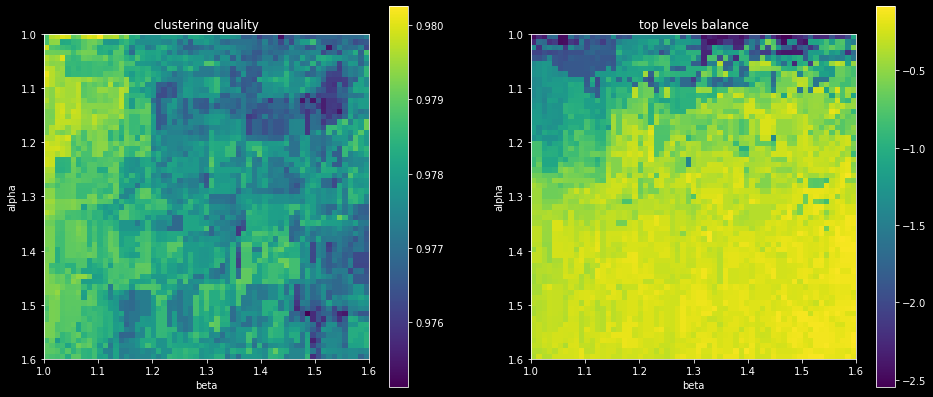

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, (ax1, ax3) = plt.subplots(figsize=(16, 7), ncols=2)
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(26, 7), ncols=3)
im1 = ax1.imshow(clustering_qualities, extent=(betas[0], betas[-1], alphas[-1], alphas[0]))
# im2 = ax2.imshow(disbalances, extent=(betas[0], betas[-1], alphas[-1], alphas[0]))
im3 = ax3.imshow(top_balances, extent=(betas[0], betas[-1], alphas[-1], alphas[0]))
fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

ax1.set_title("clustering quality")
# ax2.set_title("average leaf depth")
ax3.set_title("top levels balance")
ax1.set_xlabel("beta")
# ax2.set_xlabel("beta")
ax3.set_xlabel("beta")
ax1.set_ylabel("alpha")
# ax2.set_ylabel("alpha")
ax3.set_ylabel("alpha")

plt.show()

In [71]:
clustering_qualities[1]

[0.9794843953586074,
 0.9794284774937009,
 0.9777597794246191,
 0.9775658465039118,
 0.976727428808821,
 0.9773601116462174,
 0.9781677282554235,
 0.9776090649096952,
 0.9769052702116555,
 0.9755149285719305,
 0.9761887632783769]